<a href="https://colab.research.google.com/github/AACRobinson/IMLO-Assessment/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialisation**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io
import sklearn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode
from torch import nn
from torch.utils.data import DataLoader


if torch.cuda.is_available() :
  torch.cuda.empty_cache()
  device = 'cuda'
elif torch.backends.mps.is_available() :
  torch.backends.mps.empty_cache()
  device = 'mps'
else:
  device = 'cpu'

print("Using", device, "device\n")


trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250, 250))]) #Need to convert all images to the same tensor dimensions
                                                          ##we want these images to be large enough to for model to be able to classify with a reasonable degree of accuracy
                                                          ##yet small enough to make sure memory doesn't fill up/model trains in a reasonable amount of time
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250, 250))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250, 250))])
)

trainDataLoader = DataLoader(trainFlowers, batch_size=16, shuffle=True)
validateDataLoader = DataLoader(validateFlowers, batch_size=16, shuffle=True)
testDataLoader = DataLoader(testFlowers, batch_size=16, shuffle=True)

print(len(trainDataLoader))
print(len(validateDataLoader))
print(len(testDataLoader))
print(len(testDataLoader)//len(trainDataLoader))

Using cuda device

64
64
385
6


# **Visualisation**

In [ ]:
def showImage(dataloader) :
  train_features, train_labels = next(iter(dataloader))
  print("Feature batch shape: ", train_features.size())
  print("Labels batch shape: ", train_labels.size())
  image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 500, 500) -> (500, 500, 3)
  label = train_labels[0].item()
  plt.imshow(image)
  plt.show()
  print("Label: ", label)


def showGrid(dataset) :
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols*rows+1) :
    sample_index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(dataset[sample_index][1])
    plt.axis("off")
    plt.imshow(image.squeeze().T)
  plt.show()

# **Initial Model 4 - Taking Inspiration From LeNet5** - ~18.5% Accuracy, 0.33% Training Loss, 3.47% Validation Loss, ~1h 20 Mins

In [ ]:
trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250, 250))]) #Need to convert all images to the same tensor dimensions
                                                          ##we want these images to be large enough to for model to be able to classify with a reasonable degree of accuracy
                                                          ##yet small enough to make sure memory doesn't fill up/model trains in a reasonable amount of time
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250, 250))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=transforms.Compose([ToTensor(), Resize((250,250))])
)

trainDataLoader = DataLoader(trainFlowers, batch_size=16, shuffle=True)
validateDataLoader = DataLoader(validateFlowers, batch_size=16, shuffle=True)
testDataLoader = DataLoader(testFlowers, batch_size=16, shuffle=True)

trainFeatures, trainLabels = next(iter(trainDataLoader))
print(trainFeatures.size())
print(trainLabels.size())

torch.Size([16, 3, 250, 250])
torch.Size([16])


Epoch  1 
-------------------------------
Training Loss:  4.09
Validation Loss:  4.38 
Accuracy:  4.02 

Epoch  2 
-------------------------------
Training Loss:  3.8
Validation Loss:  4.08 
Accuracy:  9.8 

Epoch  3 
-------------------------------
Training Loss:  2.68
Validation Loss:  3.85 
Accuracy:  11.76 

Epoch  4 
-------------------------------
Training Loss:  2.87
Validation Loss:  3.7 
Accuracy:  13.33 

Epoch  5 
-------------------------------
Training Loss:  2.05
Validation Loss:  3.62 
Accuracy:  14.51 

Epoch  6 
-------------------------------
Training Loss:  2.02
Validation Loss:  3.53 
Accuracy:  15.29 

Epoch  7 
-------------------------------
Training Loss:  1.85
Validation Loss:  3.52 
Accuracy:  14.61 

Epoch  8 
-------------------------------
Training Loss:  1.51
Validation Loss:  3.51 
Accuracy:  16.27 

Epoch  9 
-------------------------------
Training Loss:  0.79
Validation Loss:  3.47 
Accuracy:  17.06 

Epoch  10 
-------------------------------
Training

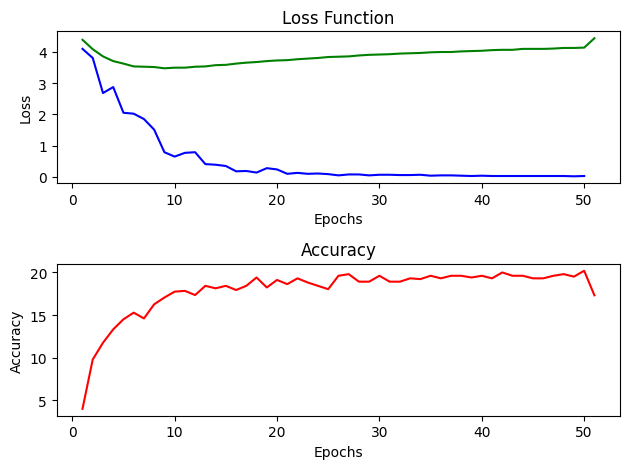

In [ ]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*250*250, 3*32*32), #About as large as is possible
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(3*16*16),
            nn.Linear(3*16*16, 3*16*16),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(3*8*8),
            nn.Linear(3*8*8, 102)
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

flowerNNModel = flowerNN().to(device)
lossFunct = nn.CrossEntropyLoss().to(device)
modelLR = 0.001
epochs = 50
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)
plotTrainingLoss = []
plotValidationLoss = []
plotAccuracy = []
fig, axs = plt.subplots(2)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  for i in range(len(testDataLoader)//len(trainDataLoader)):
    nnModel.train()
    for modelBatch, (X, y) in enumerate(dataloader) :
      prediction = nnModel(X)
      y = y.to(device)
      loss = lossFunct(prediction, y)
      loss.backward()
      modelOptimiser.step()
      modelOptimiser.zero_grad()
    loss = loss.item()
  print("Training Loss: ", round(loss, 2))
  plotTrainingLoss.append(round(loss, 2))

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    print("Validation Loss: ", round(loss, 2), "\nAccuracy: ", round((100*correct), 2), "\n")
    plotValidationLoss.append(round(loss, 2))
    plotAccuracy.append(round((100*correct), 2))

for t in range(epochs):
    print("Epoch ", t+1, "\n-------------------------------")
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimiser)
    evaluator(validateDataLoader, flowerNNModel, lossFunct)
print("Final Evaluation ", "\n-------------------------------")
evaluator(testDataLoader, flowerNNModel, lossFunct)
print("Done!\n\n")
axs[0].plot(np.arange(1, epochs+1), plotTrainingLoss, color="blue", label="Training")
axs[0].plot(np.arange(1, epochs+2), plotValidationLoss, color="green", label="Validation")
axs[0].set(xlabel="Epochs", ylabel="Loss")
axs[0].set_title("Loss Function")
axs[1].plot(np.arange(1, epochs+2), plotAccuracy, color="red")
axs[1].set(xlabel="Epochs", ylabel="Accuracy")
axs[1].set_title("Accuracy")
plt.tight_layout()
plt.show()